# Guided Project: Creating a Kaggle Workflow

In this guided project, we're going to put together all that we've learned in this course and create a data science workflow.

Data science, and particularly machine learning, contain many dimensions of complexity when compared with standard software development. In standard software development, code not working as you expect can be caused by a number of factors along two dimensions:

- Bugs in implementation
- Algorithm design
Machine learning problems, have many more dimensions:

- Bugs in implementation
- Algorithm design
- Model issues
- Data quality

We're going to explore a workflow to make competing in the Kaggle Titanic competition easier, using a pipeline of functions to reduce the number of dimensions you need to focus on.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Load data into dataframe
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

In [3]:
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


We have created a file, functions.py which contains versions of the functions we created in the earlier missions form this course, which will save you building those functions again from scratch.

In [4]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [5]:
print(train.shape, " train's size")
print(holdout.shape, " holdout's size")

(891, 12)  train's size
(418, 11)  holdout's size


In [6]:
# Applying the functions to train and holdout df
dummies_cols = ['Age_categories', 'Fare_categories', 'Title',
               'Cabin_type', 'Sex']
for item in [train, holdout]:
    item = process_missing(item)
    item = process_age(item)
    item = process_fare(item)
    item = process_titles(item)
    item = process_cabin(item)
    for col in dummies_cols:
        item = create_dummies(item, col)

In [7]:
def pre_process(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)

    for col in ["Age_categories","Fare_categories",
                "Title","Cabin_type","Sex"]:
        df = create_dummies(df,col)
    
    return df

train = pre_process(train)
holdout = pre_process(holdout)

In [8]:
print(train.shape, " train's size")
print(holdout.shape, " holdout's size")

(891, 43)  train's size
(418, 41)  holdout's size


### Feature Engineering

We're going to examine the two columns SibSp and Parch

In [9]:
train[['SibSp', 'Parch']].describe()

,SibSp,Parch
count,891.000000,891.000000
mean,0.523008,0.381594
std,1.102743,0.806057
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,8.000000,6.000000


In [10]:
train[['SibSp', 'Parch']].isnull().sum()

SibSp    0
Parch    0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0556e1add8>,
      dtype=object)

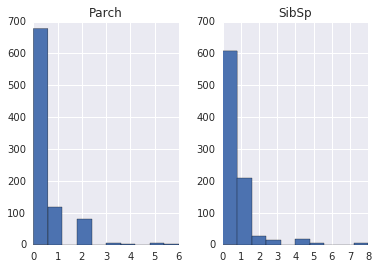

In [11]:
train[['SibSp', 'Parch']].hist()

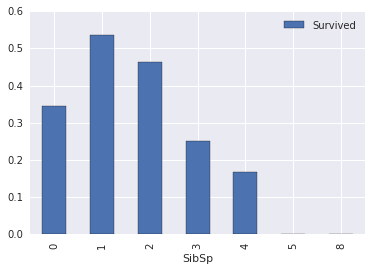

In [12]:
sibsp_pivot = train.pivot_table(index='SibSp', values='Survived')
sibsp_pivot.plot.bar()

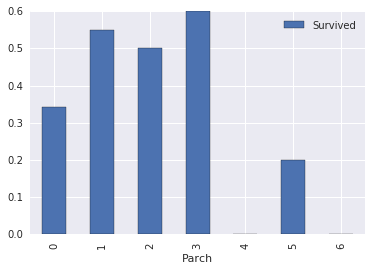

In [13]:
parch_pivot = train.pivot_table(index='Parch', values='Survived')
parch_pivot.plot.bar()

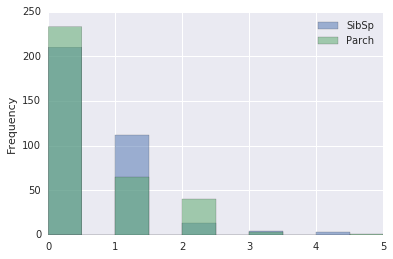

In [14]:
train.loc[train.Survived ==1,['SibSp', 'Parch']].plot(
    kind='hist', alpha=0.5)

The surviving rate goes to less number or close to zero in both SibSp and Parch columns

([<matplotlib.axis.XTick at 0x7f0555d740f0>,
 <a list of 11 Text xticklabel objects>)

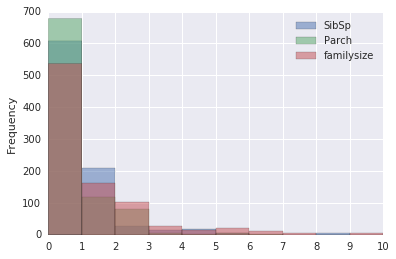

In [15]:
# Taken from the instructions
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()

explore["familysize"] = explore[["SibSp","Parch"]].sum(axis=1)
explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=10)
plt.xticks(range(11))

You should have discovered in the previous step that by combining the values of SibSp and Parch into a single column, only 30% of the passengers who had no family members onboard survived.

Based of this, we can come up with an idea for a new feature - was the passenger alone. This will be a binary column containing the value:

- 1 if the passenger has zero family members onboard
- 0 if the passenger has one or more family members onboard

### Engineering New Features

In [16]:
def process_isalone(df):
    df["familysize"] = df[["SibSp","Parch"]].sum(axis=1)
    df["isalone"] = 0
    df.loc[(df["familysize"] == 0),"isalone"] = 1
    df = df.drop("familysize",axis=1)
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)

### Feature Preparation

The next step in our workflow is feature selection. In the Feature Preparation, Selection and Engineering mission, we used scikit-learn's feature_selection.RFECV class to automate selecting the best-performing features using recursive feature elimination.

In [17]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
def select_features(df):
    # Removes any non-numeric cols or cols with null values
    select_df = df.select_dtypes([np.number]).dropna(axis=1)
    target = 'Survived'
    features = select_df.columns.tolist()
    features.remove(target)
    features.remove('PassengerId')
    
    all_X = df[features]
    all_y = df[target]
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf, cv=10)
    selector.fit(all_X, all_y)
    
    best_cols = all_X.columns[selector.support_]
    print(best_cols)
    return best_cols

best_cols = select_features(train)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Young Adult',
       'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'isalone'],
      dtype='object')


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



Just like we did with feature selection, we can can write a function to do the heavy lifting of model selection and tuning. The function we'll create will use three different algorithms and use grid search to train using different combinations of hyperparameters to find the best performing model.

We can achieve this by creating a list of dictionaries— that is, a list where each element of the list is a dictionary. Each dictionary should contain:

The name of the particular model
An estimator object for the model
A dictionary of hyperparameters that we'll use for grid search.

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    
    dict_hyperparam = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]
    
    for item in dict_hyperparam:
        print(item['name'])
        grid = GridSearchCV(item['estimator'], 
                            param_grid=item['hyperparameters'], 
                            cv=10)
        grid.fit(all_X, all_y)
        item["best_params"] = grid.best_params_
        item["best_score"] = grid.best_score_
        item["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(item["best_score"]))
        print("Best Parameters: {}\n".format(item["best_params"]))
    
    return dict_hyperparam

result = select_model(train, best_cols)

LogisticRegression
Best Score: 0.8204264870931538
Best Parameters: {'solver': 'liblinear'}

KNeighborsClassifier
Best Score: 0.7755331088664422
Best Parameters: {'weights': 'uniform', 'p': 1, 'algorithm': 'brute', 'n_neighbors': 5}

RandomForestClassifier
Best Score: 0.8294051627384961
Best Parameters: {'n_estimators': 4, 'max_features': 'log2', 'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 5, 'max_depth': 5}



If you're going to be continually submitting to Kaggle, a function will help make this easier. Let's create a function to automate this.

In [19]:
def save_submission_file(model, cols, filename="submission.csv"):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename,index=False)

best_rf_model = result[2]["best_model"]
save_submission_file(best_rf_model, best_cols)